# Interazioni statistiche {#sec-interactions} 

**Prerequisiti**

- Leggere *Understanding ‘it depends’ in ecology: a guide to hypothesising, visualising and interpreting statistical interactions* [@spake2023understanding] focalizzandosi sulla sezione *The domination of the collective: the example of mediation and moderation*.
- Leggere *The role of the individual in the coming era of process-based therapy* [@hayes2019role].

**Concetti e competenze chiave**

- Le relazioni tra variabili psicologiche possono variare in base a diversi fattori o condizioni, rendendo queste relazioni "dipendenti dal contesto".
- *Errore di Tipo D (dipendenza dal contesto non rilevata)*: Quando un'analisi statistica non riesce a rilevare la dipendenza dal contesto a causa della scala di misura scelta.
- *Errore di Tipo S (significato modificato)*: Quando la scala di modellizzazione cambia l'interpretazione di un'interazione statistica.
- *Errore di Tipo A (esplorazione asimmetrica)*: Quando l'analisi delle interazioni considera solo una direzione della relazione, ignorando la possibile bidirezionalità dell'effetto.
- *Condizionamento*: La pratica di controllare o considerare l'influenza di una variabile nel contesto di un modello, spesso usata per interpretare le interazioni.
- L'importanza di comprendere le relazioni causali sottostanti quando si interpretano le interazioni statistiche, per evitare errori inferenziali.
- Le sfide nell'analisi di potenza per le interazioni, che richiedono spesso campioni molto grandi a causa della complessità e della natura sottile degli effetti interattivi.
- La necessità di scegliere la scala di misura appropriata (additiva o moltiplicativa) per interpretare correttamente le interazioni statistiche.

**Preparazione del Notebook**

In [7]:
# Standard library imports
import os

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import scipy.stats as stats
from scipy.special import expit  # Funzione logistica
from cmdstanpy import cmdstan_path, CmdStanModel

# Configuration
seed = sum(map(ord, "missing_data"))
rng = np.random.default_rng(seed=seed)
az.style.use("arviz-darkgrid")
%config InlineBackend.figure_format = "retina"

# Define directories
home_directory = os.path.expanduser("~")
project_directory = f"{home_directory}/_repositories/psicometria"

# Print project directory to verify
print(f"Project directory: {project_directory}")

Project directory: /Users/corradocaudek/_repositories/psicometria


## Introduzione {.unnumbered}

Nel campo della psicologia, la complessità e la natura multi-causale dei fenomeni psicologici spesso portano i ricercatori a descrivere le relazioni tra variabili come "dipendenti dal contesto" [@spake2023understanding]. Questo significa che le associazioni tra variabili possono variare in base a diversi fattori o condizioni. Un concetto chiave in questo ambito è l'**interazione statistica**, che si verifica quando l'effetto di una variabile indipendente su una variabile dipendente cambia in base al livello di un'altra variabile indipendente.

Ad esempio, in un recente studio di @Pines2024, è stato osservato che le relazioni tra cognizione e salute mentale nei bambini possono essere sia positive che negative, a seconda del contesto. In particolare, la relazione tra cognizione e salute mentale varia significativamente in base alla popolazione studiata. Se si considerano bambini generalmente sani con pochi sintomi isolati, potrebbe emergere una relazione diversa rispetto a un campione di bambini con sintomi di gravità clinica.

Nello studio di @Pines2024, è stato evidenziato che la direzione della relazione tra cognizione e salute mentale nei bambini cambia in modo significativo a seconda della gravità dei sintomi. Per i sintomi internalizzanti (come ansia e depressione), si è osservato che i bambini con pochi sintomi tendono ad avere punteggi cognitivi più alti rispetto ai bambini senza sintomi, mentre i bambini con sintomi gravi mostrano una cognizione compromessa. Questo cambiamento nella direzione della relazione, a seconda della gravità dei sintomi, rappresenta un esempio di interazione statistica.

Per quanto riguarda i sintomi esternalizzanti (come comportamenti aggressivi), la pendenza della relazione tra cognizione e salute mentale può variare a seconda della gravità dei sintomi, ma la direzione dell'associazione rimane invariata.

Questo esempio dimostra che, quando si parla di interazioni statistiche, è fondamentale considerare come il contesto e le caratteristiche specifiche dei partecipanti possano influenzare le relazioni tra le variabili. @Pines2024 sottolineano che, se l'obiettivo dello studio è comprendere il ruolo della cognizione nella psicopatologia, è essenziale includere individui con sintomi di gravità clinica. Questo perché le relazioni osservate in campioni sani potrebbero non solo non generalizzarsi a campioni clinici, ma potrebbero anche mostrare associazioni opposte.

In sintesi, l'interazione statistica ci aiuta a comprendere come le relazioni tra variabili possano cambiare a seconda delle condizioni o dei gruppi specifici, evidenziando l'importanza di un approccio attento e contestualizzato nella ricerca psicologica. Studiare le dipendenze tra i fattori psicologici ha sia motivazioni pratiche che teoriche. Ad esempio, identificare effetti interattivi può aiutare a indirizzare le risorse di intervento in contesti in cui queste saranno più efficaci, mentre l'assenza di interazioni potrebbe suggerire l'esistenza di relazioni generali in uno specifico dominio psicologico.

@spake2023understanding si chiede se un fattore di interesse abbia un effetto che "dipende da" o viene "modificato" in magnitudine o segno da altri fattori. Potrebbe sembrare che la risposta a questa domanda sia semplice utilizzando mezzi grafici come i grafici condizionali (valori previsti di Y tracciati lungo l'intervallo di X e Z, o a valori significativi di questi predittori) o esaminando gli effetti marginali (gli effetti marginali riassumono l'effetto di una variabile indipendente sulla risposta in termini di previsioni di un modello). Tuttavia, tali analisi sono vulnerabili a diverse potenziali interpretazioni errate, che emergono quando si trascurano due aspetti critici della modifica dell'effetto: la scala (se una risposta è analizzata su una scala additiva o moltiplicativa) e la simmetria (se la modifica dell'effetto è esaminata in entrambe le direzioni).

Nel loro articolo, @spake2023understanding analizzano gli errori inferenziali che possono sorgere quando la scala e la simmetria della modifica dell'effetto vengono trascurate negli studi di ricerca. Iniziano illustrando con dati empirici e simulazioni come gli errori di tipo D, S e A possano derivare dall'ignorare la scala e la simmetria delle interazioni, anche quando un modello è correttamente specificato.

## La dipendenza dal contesto può passare inosservata (Errore di Tipo D)

Il modo più comune per testare la dipendenza dal contesto è introdurre un'interazione statistica (X × Z) in un modello. Le interazioni statistiche indicano che la relazione tra X e Y varia lungo l'intervallo di Z; analogamente, le relazioni Z–Y variano lungo l'intervallo di X (Duncan & Kefford, 2021). Il supporto statistico per un'interazione è poi determinato, ad esempio, utilizzando criteri di selezione del modello per giustificarne l'inclusione in modelli concorrenti (ad esempio, il criterio di informazione di Akaike, AIC).

Tuttavia, il fatto che un termine di interazione sia supportato o meno può dipendere criticamente dalla scala di misura utilizzata per stimare gli effetti in un modello statistico, ovvero se la scala di misura è additiva (ad esempio, unità assolute) o moltiplicativa (ad esempio, log-trasformata).

![**Tre errori inferenziali comuni nell'investigazione della dipendenza dal contesto.** Consideriamo un test di dipendenza dal contesto nella sua forma più semplice: un esperimento fattoriale 2 × 2, che misura una risposta Y in relazione all'incrocio dei fattori X e Z, ciascuno con due livelli. L'analista adatta ai dati un modello statistico con un termine di interazione: \(Y \sim X + Z + X \times Z\), per testare e quantificare la dipendenza dal contesto. Sono possibili tre errori inferenziali quando si trascurano la scala di misurazione o la simmetria dell'interazione: la rilevazione e la grandezza (Tipo D), il segno (Tipo S) e la mancata identificazione dei processi sottostanti (Tipo A) (figura tratta da @spake2023understanding).](../../figures/interactions_errors.png){ width=90% }

## Mediazione e moderazione

L’articolo di Baron e Kenny (1986) ha rappresentato un punto di riferimento fondamentale per l’analisi della mediazione e della moderazione, influenzando numerosi studi successivi. In questo lavoro, gli autori hanno descritto il mediatore come il meccanismo attraverso il quale la variabile indipendente principale esercita un effetto sulla variabile dipendente di interesse (Baron & Kenny, 1986, p. 1173). In altre parole, il mediatore spiega "come" o "perché" si verifica questa relazione. D'altra parte, hanno definito il moderatore come una variabile che altera l’intensità o la direzione della relazione tra la variabile indipendente e la variabile dipendente (Baron & Kenny, 1986, p. 1174). Il moderatore ci dice "quando" o "in quali condizioni" si verifica l'effetto.

Si parla di mediazione completa quando il legame tra due variabili, A e C, viene eliminato dopo aver controllato per il mediatore B (Baron & Kenny, 1986). Se, invece, la variabile A continua ad avere un effetto diretto su C, oltre a quello indiretto mediato da B, si ha una mediazione parziale (James & Brett, 1984).

Per studiare mediatori e moderatori, si utilizzano spesso tecniche come l'analisi della varianza (ANOVA), i modelli di regressione e i modelli a equazioni strutturali (SEM) (Baron & Kenny, 1986; Holmbeck, 1997; Judd & Kenny, 1981). Questi metodi sono progettati per indagare la direzione causale degli effetti mediatori (Smith, 1982), distinguere tra mediazione completa e parziale (Holmbeck, 1997; Sobel, 1982), e anche testare modelli che combinano sia mediazione che moderazione (Baron & Kenny, 1986).

È importante sottolineare che, così come vengono comunemente condotte, queste analisi presentano notevoli limitazioni nell'informare un approccio basato sui processi per spiegare i fenomeni psicologici [@hayes2019role]. I concetti di mediazione completa e parziale riguardano inferenze sui parametri di popolazione, ma non possono essere estesi ai singoli partecipanti di uno studio, né applicati alle persone, e nemmeno riferiti alle cause specifiche che operano a livello individuale [@grice2015muddled].

### Le interazioni statistiche dipendono dalla scala di misura

Un altro problema relativo alle interazioni riguarda la loro stessa misurazione [@spake2023understanding]. Le interazioni statistiche, come quelle osservate in un esperimento fattoriale 2x2, sono influenzate dalla scala di misura utilizzata. La rilevazione di un'interazione dipende dal fatto che le linee di un grafico di interazione (che connettono le medie di uno stesso livello di un fattore attraverso i livelli di un altro) siano parallele o meno. Tuttavia, il grado di divergenza dal parallelismo può variare a seconda della scala di misura adottata. Se X e Z influenzano Y in modo indipendente, allora:

- Se non c'è una modifica nell'effetto assoluto di X su Y con diversi valori di Z (cioè, le linee sono parallele su una scala additiva), allora l'effetto relativo di X su Y varierà con Z (le linee non saranno parallele su una scala moltiplicativa).
- Al contrario, se l'effetto relativo di X su Y rimane costante per diversi valori di Z (cioè, le linee sono parallele su una scala moltiplicativa), allora l'effetto assoluto di X su Y cambierà con Z su una scala additiva.

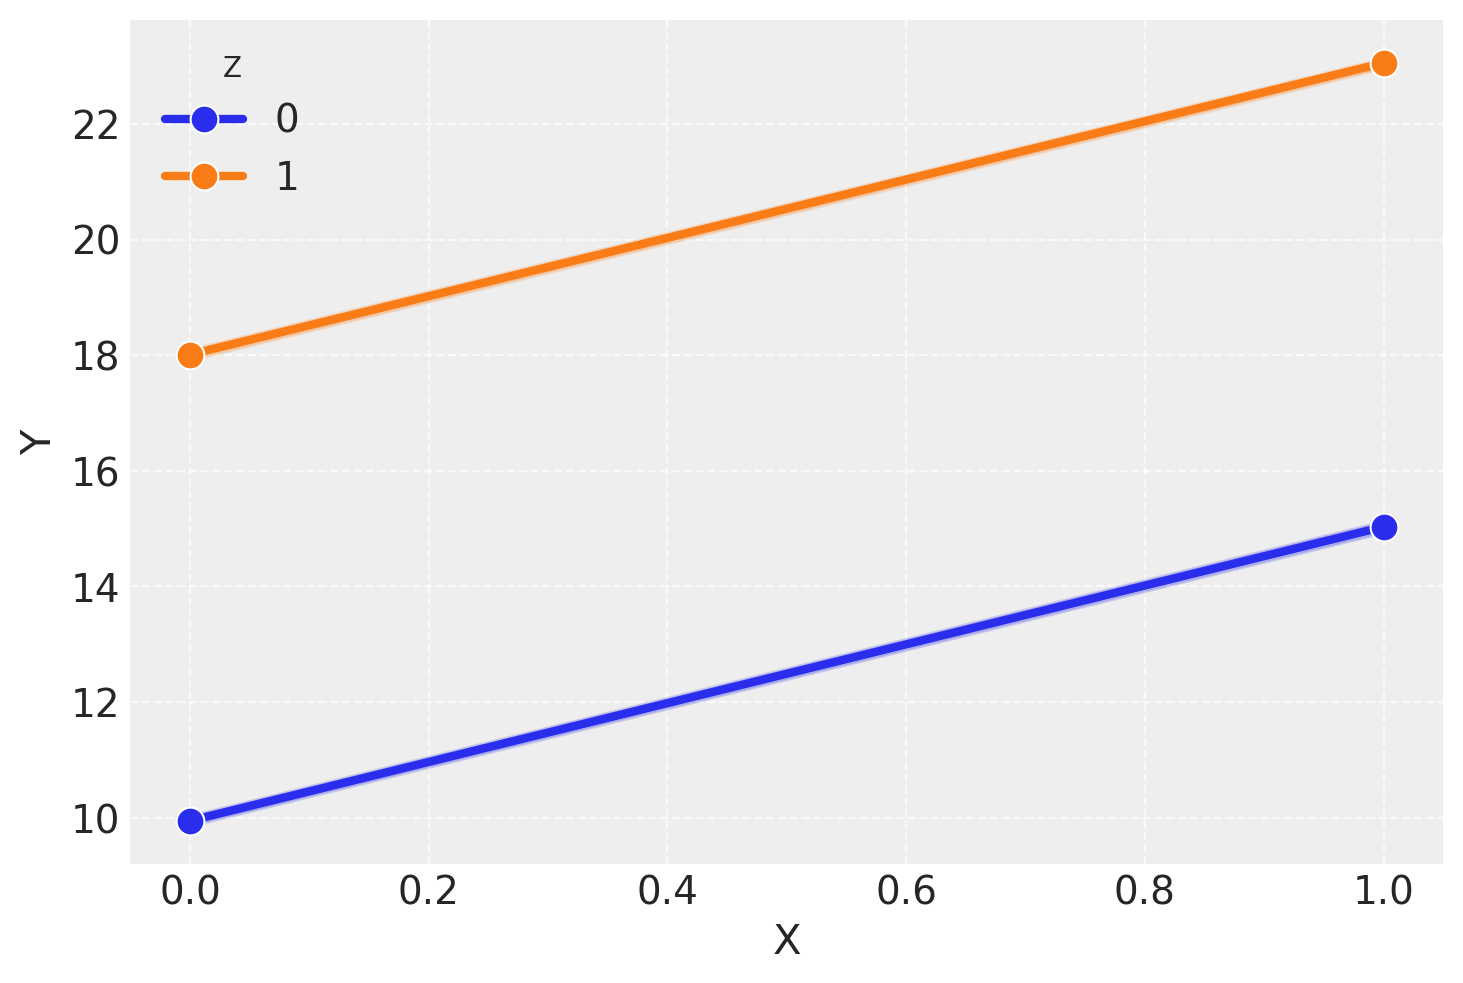

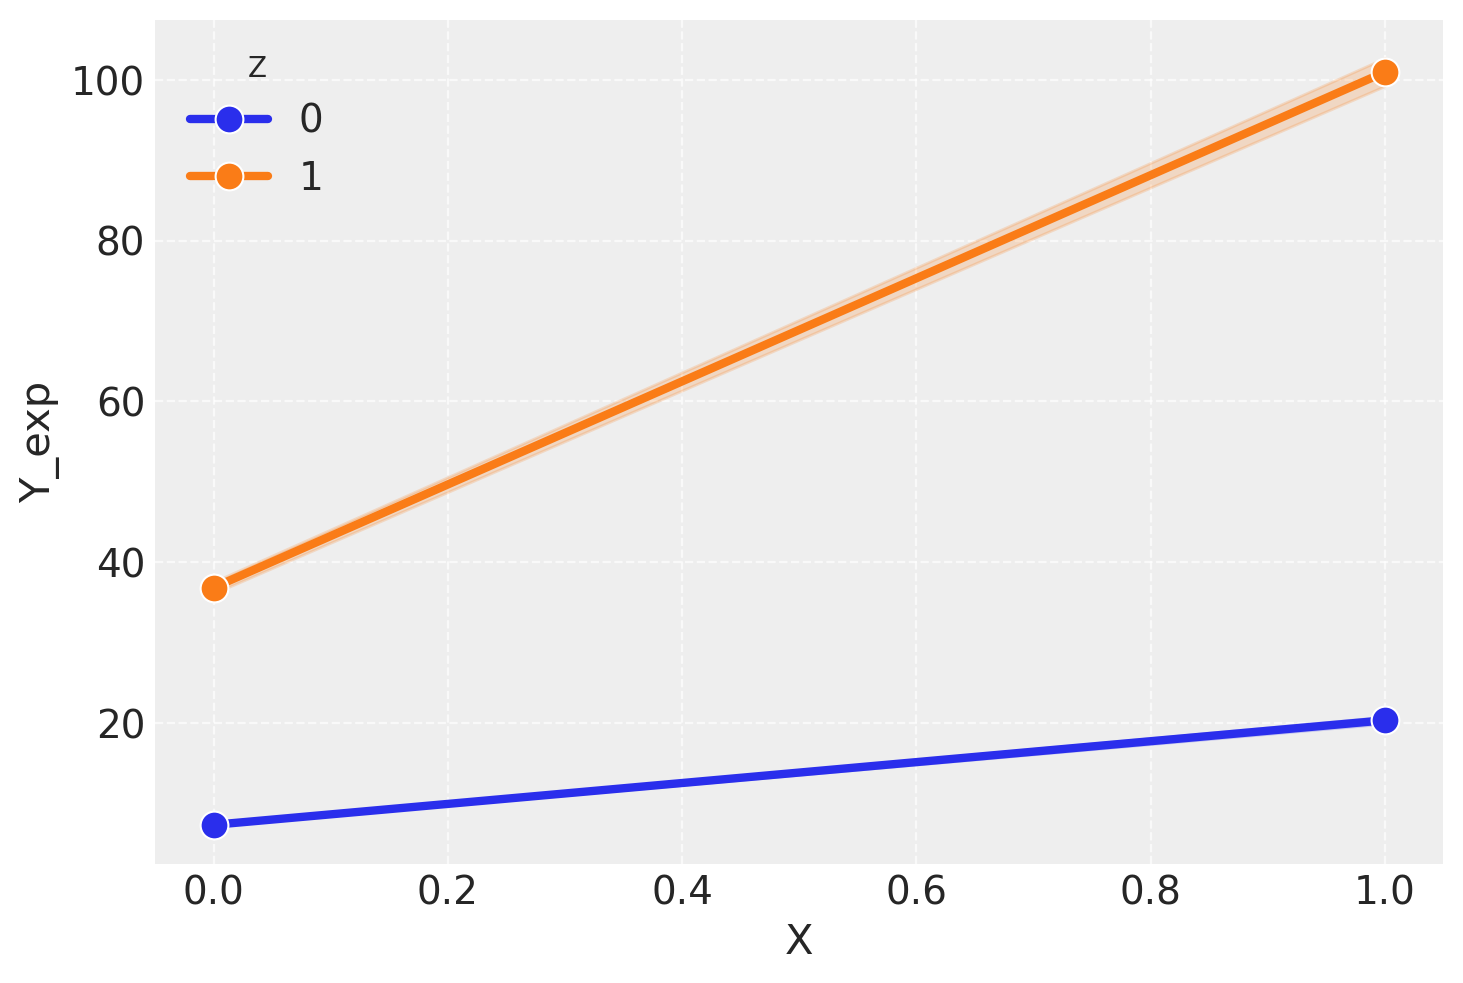

In [11]:
# Funzione per generare i dati
def genera_dati(n_per_gruppo=100):
    np.random.seed(42)
    data = []
    for x in [0, 1]:
        for z in [0, 1]:
            y = 10 + 5 * x + 8 * z + np.random.normal(0, 0.5, n_per_gruppo)
            data.extend([(x, z, yi) for yi in y])
    return pd.DataFrame(data, columns=["X", "Z", "Y"])


# Genera il dataframe
df = genera_dati()


# Funzione per creare il grafico di interazione
def plot_interazione(data, y_col, title):
    sns.lineplot(
        data=data, x="X", y=y_col, hue="Z", marker="o", markersize=10, linewidth=3
    )
    plt.legend(title="Z")
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.show()


# Grafico sulla scala originale
plot_interazione(df, "Y", "Interazione sulla Scala Originale (Additiva)")

# Trasforma Y su una scala esponenziale più drastica
df["Y_exp"] = np.exp(df["Y"] / 5)

# Grafico sulla scala trasformata
plot_interazione(df, "Y_exp", "Interazione sulla Scala Trasformata (Esponenziale)")

Nella simulazione presentata, osserviamo due scenari chiave:

1. Scala Originaria (Additiva):
   - I dati sulla scala originaria non mostrano interazione.
   - Le linee nel grafico sono parallele, indicando che l'effetto di X su Y è costante per diversi livelli di Z.
   - Questo parallelismo suggerisce che gli effetti di X e Z su Y sono additivi e indipendenti.

2. Scala Trasformata (Esponenziale):
   - Applicando una trasformazione esponenziale ai dati originari, emerge un'apparente interazione.
   - Le linee nel grafico non sono più parallele, suggerendo che l'effetto di X su Y varia a seconda del livello di Z.

È importante notare che:

- La presenza o assenza di interazione dipende dalla scala di misura utilizzata.
- La trasformazione non crea o elimina relazioni reali tra le variabili, ma cambia il modo in cui interpretiamo queste relazioni.

Consideriamo il caso inverso:

- Se il secondo grafico (con interazione apparente) rappresentasse i dati grezzi, una trasformazione logaritmica potrebbe produrre un grafico simile al primo, mostrando assenza di interazione.
- Questo perché la funzione logaritmica è l'inversa della funzione esponenziale.
- In generale, se abbiamo dati che mostrano interazione su una scala moltiplicativa, una trasformazione logaritmica potrebbe rivelare una relazione additiva senza interazione.

@spake2023understanding notano inoltre che esistono due tipi di interazioni:

- **Interazioni non rimovibili (crossover o qualitative)**: queste coinvolgono un cambiamento nel segno di un effetto e non possono essere eliminate attraverso una trasformazione monotona della scala di misura.
- **Interazioni rimovibili**: queste possono essere eliminate cambiando la scala di misura e sono particolarmente soggette a errori di tipo D (falsi negativi) e S (falsi positivi).

In conclusione,

- la scelta della scala appropriata dovrebbe essere guidata dalla teoria sottostante e dalla natura dei dati, non solo dall'aspetto visivo dei grafici;
- è sempre consigliabile esaminare i dati su diverse scale e considerare attentamente quale scala sia più appropriata per l'interpretazione nel contesto specifico della ricerca.

## La scala di modellizzazione può cambiare il significato di un'interazione statistica (Errore di Tipo S)

Nel pannello B della figura di @spake2023understanding, viene mostrato come il significato di un'interazione statistica possa cambiare a seconda della scala di modellizzazione utilizzata: nel pannello di sinistra, l'effetto di Z diventa meno negativo man mano che X aumenta, mentre nel pannello di destra, l'effetto di Z diventa più negativo con l'aumentare di X.

Le scale additive indicano che l'effetto combinato di due predittori è semplicemente la somma dei loro effetti individuali. Al contrario, le scale moltiplicative, spesso utilizzate nei modelli lineari generalizzati (GLM), suggeriscono che l'effetto combinato è il prodotto degli effetti individuali. Questo cambiamento nel significato dell'interazione è dovuto alla natura non lineare delle funzioni di collegamento nei GLM, il che implica che l'effetto marginale di un predittore può variare in base ai valori degli altri predittori, anche se non sono presenti termini di interazione espliciti.

### Quale scala di misura è più appropriata: additiva o moltiplicativa?

La scelta tra scala additiva e moltiplicativa dipende dal contesto e dagli obiettivi dell'analisi. La scala additiva è spesso considerata più rilevante per la formulazione di politiche perché consente di valutare cambiamenti assoluti, utili per determinare l'impatto di interventi su specifici gruppi. La scala moltiplicativa è utile per comprendere processi relativi, come i tassi di crescita delle popolazioni. In molti casi, è utile presentare e interpretare entrambi i tipi di misure per fornire una comprensione completa dell'effetto di interazioni complesse. 

In sintesi, le interazioni statistiche sono intrinsecamente dipendenti dalla scala di misura. La corretta interpretazione di queste interazioni richiede attenzione alla scala scelta per modellare i dati e alle implicazioni che questa scelta ha per le conclusioni inferenziali e la rilevanza pratica dei risultati ottenuti. È essenziale non basarsi solo sulla significatività statistica, ma anche considerare il significato scientifico o pratico degli effetti osservati.

## Le esplorazioni asimmetriche della dipendenza dal contesto non sono sufficienti per interpretare le interazioni (Errore di Tipo A)

@spake2023understanding descrivono l'errore di *Tipo A* che si verifica quando si esplorano in modo asimmetrico le dipendenze dal contesto nelle interazioni statistiche (si veda il pannello C della figura di @spake2023understanding). Ciò avviene quando si tratta una variabile come "effetto principale" e l'altra come "modificatore" senza considerare che la relazione potrebbe funzionare in entrambe le direzioni. Questo approccio può portare a una comprensione incompleta o fuorviante dei processi sottostanti.

Nelle ricerche psicologiche, è comune testare come un "modificatore" (variabile Z) influenzi l'effetto di una variabile di interesse principale (variabile X). Questo approccio è spesso giustificato perché la variabile X può essere manipolata direttamente o rappresenta una variabile di "trattamento", mentre Z è un contesto che non può essere facilmente cambiato. Tuttavia, visualizzare e interpretare le interazioni solo in una direzione (come l'effetto di X su Y modificato da Z) può portare a errori, poiché questa visione potrebbe non riflettere tutte le possibili relazioni condizionali tra X, Y, e Z.

Consideriamo un esempio in cui studiamo l'effetto dello *stress* (X) sulla *performance cognitiva* (Y), e ipotizziamo che questo effetto sia modificato dal *supporto sociale* (Z).

- **Ipotesi Asimmetrica**: Formuliamo l'ipotesi che il supporto sociale (Z) moderi l'effetto dello stress (X) sulla performance cognitiva (Y). Ci aspettiamo che con maggiore supporto sociale, lo stress abbia un impatto minore sulla performance cognitiva. Così, X (stress) è l'effetto principale e Z (supporto sociale) è il modificatore. Costruiamo un modello che include un termine di interazione (stress × supporto sociale) e visualizziamo un grafico degli effetti marginali che mostra come l'effetto dello stress sulla performance cognitiva cambi con diversi livelli di supporto sociale.

  - **Risultato Potenziale**: Il grafico mostra che, con alto supporto sociale, l'effetto negativo dello stress sulla performance cognitiva è ridotto. Concludiamo che il supporto sociale può aiutare a mitigare gli effetti negativi dello stress, promuovendo quindi interventi per aumentare il supporto sociale nei contesti lavorativi.

- **Ipotesi Completa**: Se esaminiamo l'interazione in modo simmetrico, potremmo anche considerare come lo stress modera l'effetto del supporto sociale sulla performance cognitiva. Questa prospettiva potrebbe rivelare, per esempio, che in condizioni di basso stress, il supporto sociale non ha alcun effetto sulla performance cognitiva, o addirittura che troppo supporto sociale in condizioni di basso stress potrebbe ridurre l'autonomia e la performance.

  - **Risultato Potenziale**: Visualizzando gli effetti marginali in entrambe le direzioni (supporto sociale che modera lo stress e viceversa), scopriamo che l'effetto del supporto sociale è positivo solo sotto condizioni di stress elevato, ma negativo quando lo stress è basso. Questo ci suggerisce che promuovere il supporto sociale dovrebbe essere mirato solo a contesti di stress elevato, cambiando completamente la nostra interpretazione e le nostre raccomandazioni.

In sintesi, l'errore di Tipo A evidenzia l'importanza di esaminare le interazioni in modo simmetrico e di considerare come entrambe le variabili possano influenzarsi reciprocamente. In psicologia, ciò potrebbe significare guardare non solo come una variabile contesto influenzi un effetto principale, ma anche come l'effetto principale possa a sua volta modificare l'influenza della variabile contesto. Trascurare questa bidirezionalità può portare a conclusioni incomplete e ad interventi inefficaci.

## Interazione e Condizionamento

@McElreath_rethinking mette in relazione il concetto di interazione con quello di condizionamento e illustra il concetto di condizionamento utilizzando l'analogia con i bombardieri A.W.38 durante la Seconda Guerra Mondiale. Durante la guerra, i bombardieri A.W.38 della Royal Air Force erano spesso bersagliati da artiglieria e fuoco di intercettazione. Molti di questi aerei non tornavano dalle missioni, ma quelli che riuscivano a tornare portavano evidenti segni di danno. Inizialmente, sembrava logico aggiungere armature nelle aree degli aerei che mostravano più danni, come ali e fusoliera. Tuttavia, questo approccio si basava su un errore di condizionamento.

*Condizionamento* significa che i dati che osserviamo (i danni sui bombardieri che sono tornati) sono condizionati dal fatto che questi bombardieri sono sopravvissuti. I bombardieri che tornavano alla base mostravano danni in parti non essenziali per il volo, come le ali. Le parti che risultavano intatte (cabina di pilotaggio e motori) erano in realtà le più critiche: se fossero state danneggiate, l'aereo non sarebbe tornato affatto. Pertanto, per migliorare la sopravvivenza dei bombardieri, si sarebbe dovuto armare le parti che non mostravano danni nei bombardieri sopravvissuti, perché queste erano le parti che, se colpite, avrebbero causato la perdita dell'aereo.

Il principio del condizionamento è fondamentale per l'inferenza statistica. Indica che i dati che osserviamo sono spesso condizionati da come entrano nel nostro campione, cioè da un insieme di condizioni preesistenti. Nel caso dei bombardieri, i danni osservati sono condizionati dal fatto che l'aereo sia riuscito a tornare alla base.

Analogamente, nelle analisi statistiche, dobbiamo considerare che le distribuzioni posteriori (cioè, la probabilità di un certo parametro dato i dati osservati) sono condizionate dai dati stessi. L'inferenza basata su modelli è condizionata dal modello scelto. Ogni inferenza statistica è condizionata da qualcosa, anche se non ce ne rendiamo sempre conto.

Per quel che riguarda la discussione presente, possiamo sottolineare che il condizionamento è anche alla base delle interazioni nei modelli statistici. Per esempio, se vogliamo permettere che l'associazione tra due variabili dipenda da una terza variabile, stiamo applicando un condizionamento. In un modello lineare, una *interazione* permette che l'effetto di un predittore vari in base ai valori di un altro predittore. Questo è un esempio di come un parametro può essere condizionato da ulteriori aspetti dei dati.

## Interazione e nessi causali

@McElreath_rethinking, nel suo libro "Statistical Rethinking", solleva un punto cruciale riguardo all'analisi delle interazioni statistiche. Egli sottolinea che esaminare un'interazione, ovvero valutare se l'associazione tra due variabili dipende da una terza, implica essenzialmente un processo di condizionamento. In altre parole, si tratta di "controllare" l'effetto di una variabile nel contesto di un modello di regressione. Tuttavia, @McElreath_rethinking avverte che la decisione di condizionare su una variabile non è sempre appropriata o sensata, ma dipende criticamente dalle relazioni causali che intercorrono tra le variabili in esame.

Questo concetto si ricollega direttamente alle discussioni sull'inferenza causale. Come è stato evidenziato nel @sec-causal-inference-regr, è fondamentale condizionare sui confondenti, ovvero quelle variabili che influenzano sia la variabile indipendente che quella dipendente. D'altra parte, è metodologicamente errato condizionare su un discendente, cioè una variabile che è influenzata dalla variabile dipendente o da quella indipendente. Questa distinzione ha implicazioni profonde per l'analisi delle interazioni.

Di conseguenza, la quantificazione degli effetti dell'interazione non può essere considerata un'operazione "statisticamente neutra" o universalmente applicabile. La sua validità e interpretazione dipendono strettamente dalla struttura causale sottostante al fenomeno studiato. Senza una comprensione approfondita delle relazioni causali tra le variabili, l'esame delle interazioni statistiche può facilmente portare a conclusioni fuorvianti o errate. Un approccio puramente statistico, che non tenga conto del contesto causale, rischia di condurre a interpretazioni fallaci dei risultati.

Per condurre un'analisi delle interazioni robusta e significativa, è quindi essenziale integrare la conoscenza specifica del dominio con i metodi statistici. Questo richiede una comprensione dettagliata dei meccanismi causali potenziali nel sistema studiato. Prima di esaminare le interazioni, è cruciale sviluppare un modello causale, anche se preliminare, delle relazioni tra le variabili. L'utilizzo di strumenti come i diagrammi causali (DAG - Directed Acyclic Graphs) può essere di grande aiuto per visualizzare e analizzare queste relazioni causali.

L'approccio consigliato è quindi quello di basare l'analisi delle interazioni su ipotesi causali ben fondate, piuttosto che su pure associazioni statistiche. Questo metodo sottolinea l'importanza di una progettazione attenta degli studi e di una riflessione approfondita sulle relazioni causali prima dell'analisi dei dati. Tale approccio può portare a una rivalutazione di molte pratiche comuni nell'analisi statistica, specialmente in campi dove le relazioni causali sono complesse o non completamente comprese.

In conclusione, l'analisi delle interazioni statistiche richiede una comprensione approfondita del contesto causale. Un approccio che integra la teoria causale con l'analisi statistica è essenziale per trarre conclusioni valide e significative dalle interazioni osservate nei dati. Senza questa integrazione, l'esame delle interazioni statistiche in maniera ingenua può essere molto rischioso e potenzialmente fuorviante.

## Misurare le interazioni

Una caratteristica fondamentale di una buona pratica di ricerca è testare le ipotesi con un potere statistico adeguato. Condurre studi con un alto potere statistico aumenta la probabilità di documentare non solo effetti reali, ma anche effetti replicabili. Mentre l'analisi della potenza per gli effetti principali è relativamente semplice, l'analisi della potenza per le interazioni di primo ordine (cioè le interazioni a due vie, che qui chiameremo semplicemente "interazioni") presenta due importanti sfide.

In primo luogo, condurre un'analisi di potenza appropriata per le interazioni non è facilmente realizzabile con software come G*Power (Faul et al., 2007) o pacchetti R come `pwr` (Champely et al., 2017), perché la dimensione dell'effetto attesa di un'interazione dipende dalla sua forma (Maxwell & Delaney, 2004). In secondo luogo, ottenere un potere sufficiente per rilevare le interazioni non è un compito facile, poiché le dimensioni degli effetti delle interazioni sono spesso piccole e, di conseguenza, la dimensione del campione necessaria è spesso molto grande (Brysbaert, 2019).

Nelle simulazioni condotte da @sommet2023many, diversi tipi di interazioni sono stati esaminati per determinare la dimensione del campione necessaria a ottenere un potere di 0.8 con una piccola dimensione dell'effetto atteso. 

1. **Interazione di tipo "reversed" (invertita)**: Se l'interazione mostra un effetto invertito, è necessaria una dimensione campionaria di N = 784 per ottenere un potere di 0.8.

2. **Interazione "fully attenuated" (completamente attenuata)**: Quando l'interazione è completamente attenuata, il che significa che l'effetto è notevolmente ridotto o quasi nullo in determinate condizioni, la dimensione campionaria necessaria per ottenere un potere di 0.8 sale a N = 3136.

3. **Interazione "partially attenuated" (parzialmente attenuata)**: Per un'interazione parzialmente attenuata, dove l'effetto è ridotto solo parzialmente in alcune condizioni, è necessaria una dimensione campionaria di N = 5575 per raggiungere un potere di 0.8.

[Andrew Gelman](https://statmodeling.stat.columbia.edu/2018/03/15/need-16-times-sample-size-estimate-interaction-estimate-main-effect/) ha sottolineato che per stimare un'interazione è necessaria una dimensione del campione 16 volte maggiore rispetto a quella necessaria per stimare un effetto principale. In generale, possiamo dire che questa differenza, e i risultati delle simulazioni di @sommet2023many presentati sopra, si spiegano con la natura delle interazioni: esse rappresentano effetti più sottili e complessi rispetto agli effetti principali, in quanto descrivono come l'effetto di una variabile cambia in funzione dei livelli di un'altra variabile. Questo livello aggiuntivo di complessità richiede una maggiore quantità di dati per essere rilevato e stimato con precisione.

Inoltre, la forma delle interazioni e il modo in cui le pendenze semplici (gli effetti principali a livelli specifici di un’altra variabile) si intersecano dipendono dalla grandezza dell'effetto di interazione rispetto alla magnitudine degli effetti principali. Questo rapporto determina se l'interazione produce:

- **Un effetto attenuato**: l'effetto di una variabile è ridotto, ma non eliminato, dalla presenza di un'altra variabile.
- **Un effetto "knock-out"**: l'effetto di una variabile è completamente eliminato in presenza di un'altra variabile.
- **Un effetto "crossover"**: l'effetto di una variabile si inverte in presenza di un'altra variabile, mostrando un cambiamento completo nella direzione dell'effetto.

Ciascuno di questi scenari richiede una quantità notevole di dati per essere adeguatamente caratterizzato e distinto dagli effetti principali.

In sintesi, le interazioni richiedono un maggiore potere statistico rispetto agli effetti principali in un modello di regressione, poiché rappresentano effetti più complessi che necessitano di una maggiore quantità di dati per essere rilevati e stimati con precisione. La loro dipendenza dal contesto e la relazione con gli effetti principali rendono necessario un campione più ampio per distinguerle in modo affidabile dal rumore statistico e caratterizzarle adeguatamente.

## Commenti e considerazioni conclusive

Questo capitolo ha introdotto il concetto di interazione, che permette di considerare come l'associazione tra un predittore e un esito possa dipendere dal valore di un altro predittore. Le interazioni sono importanti per fare inferenze accurate, ma possono risultare difficili da interpretare. 

Nel capitolo, abbiamo esaminato tre tipi di errori comuni nell'interpretazione delle interazioni, come illustrato da @spake2023understanding. Inoltre, abbiamo discusso alcune considerazioni presentate da @McElreath_rethinking, che collegano il concetto di interazione a quello di condizionamento e, di conseguenza, all'analisi causale. Infine, abbiamo esplorato le considerazioni relative alla dimensione campionaria necessaria per rilevare e misurare correttamente le interazioni.

## Informazioni sull'Ambiente di Sviluppo {.unnumbered}

In [13]:
%load_ext watermark
%watermark -n -u -v -iv -w -m

Last updated: Thu Jun 13 2024

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 8.25.0

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.4.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

matplotlib : 3.8.4
pandas     : 2.2.2
statsmodels: 0.14.2
arviz      : 0.18.0
numpy      : 1.26.4
seaborn    : 0.13.2
xarray     : 2024.5.0
scipy      : 1.13.1

Watermark: 2.4.3

